In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Building a Full ML Pipeline

Now that we've learned how to use individual parts of scikit-learn, let's put things together to build a full machine learning pipeline to perform facial recognition.

First, we'll download the data and take a look at it.

In [5]:
from sklearn.datasets import fetch_olivetti_faces

people = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/samdixon/scikit_learn_data


In [16]:
print(people.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



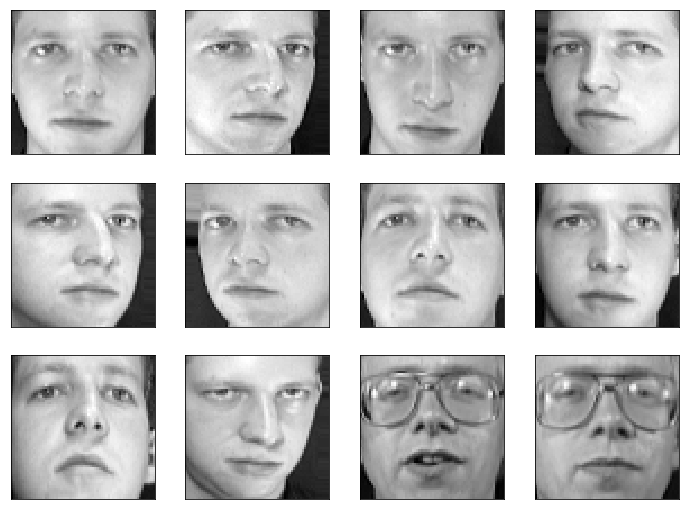

In [17]:
plt.figure(figsize=(12, 9))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(people.images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [18]:
print(people.data.shape)

(400, 4096)


Using the full data vector to try to predict the subject's identity would probably not perform very well and would be computationally expensive. We'll preprocess the data by doing a principal component analysis (PCA) to reduce the dimensionality of the data.

PCA projects a high-dimensional vector into a low-dimensional space using Singular Value Decomposition. This effectively decomposes the data into a set of orthogonal components that each attempt to explain the maximum amount of variance.

Let's find some eigenfaces:

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(people.data, people.target, test_size=0.25)

In [63]:
from sklearn.decomposition import PCA

n_components = 150
pca = PCA(n_components=n_components)
pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, 64, 64))

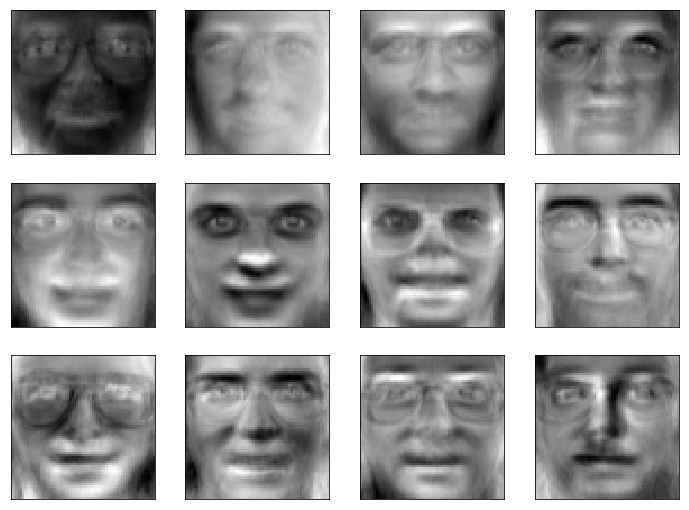

In [64]:
plt.figure(figsize=(12, 9))
for i, face in enumerate(eigenfaces[:12]):
    plt.subplot(3, 4, i+1)
    plt.imshow(face, cmap='gray')
    plt.xticks([])
    plt.yticks([])

Each of these eigenfaces is one of the orthogonal basis vectors of our training set. By projecting each face into this basis, we reduce the length of the data vector from 4096 to one with length $n_{components}$. The reverse process is also possible. Let's look at a face reconstructed from its eigenface projection.

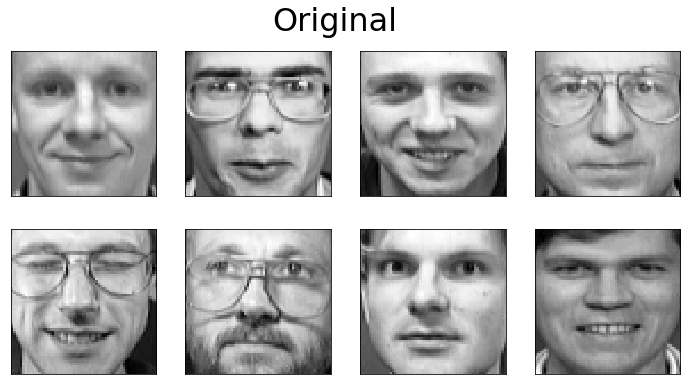

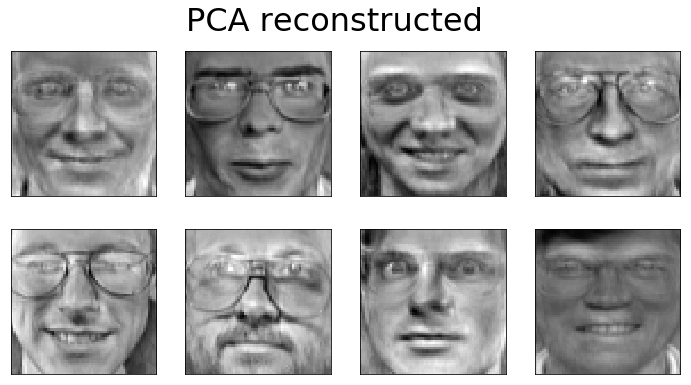

In [65]:
X_train_pca = pca.transform(X_train)
reconstructed_X_train = np.tensordot(X_train_pca, eigenfaces, axes=(-1, 0))

plt.figure(figsize=(12, 6))
for i, face in enumerate(X_train[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(face.reshape((64, 64)), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Original', fontsize=32)
plt.show()

plt.figure(figsize=(12, 6))
for i, face in enumerate(reconstructed_X_train[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(face, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('PCA reconstructed', fontsize=32)
plt.show()

Now, we'll use the lower-dimensional vectors describing the faces in the dataset to train a support vector machine to do the subject classification. A full discussion of SVM is beyond the scope of this tutorial, so we will treat it as a black box classifier. We'll use grid search cross-validation to find the best values of the hyperparameters used in the SVM.

In [66]:
# Project training and test sets into the PCA eigenbasis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Train the SVM classifier using cross-validation to tune parameters
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [1e-4, 5e-4, 1e-3, 5e-3, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

Let's see how well the SVM did. We'll use a confusion matrix to visualize the accuracy of the predictions from the SVM.

Text(0,0.5,'Actual label')

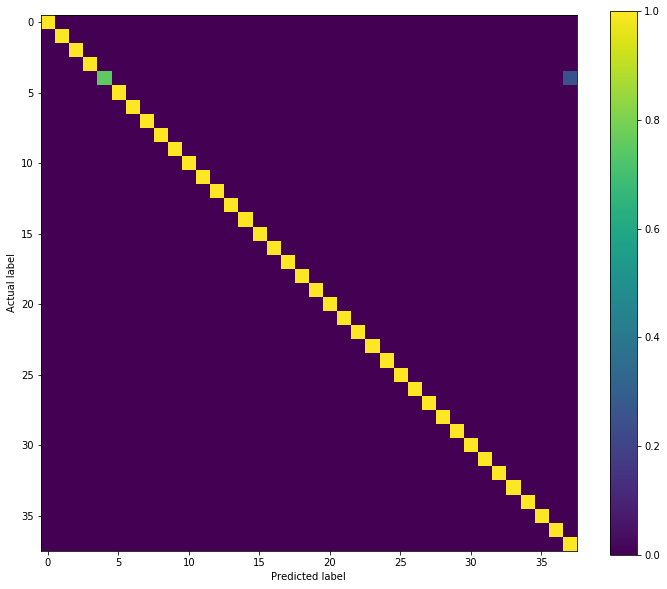

In [70]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, clf.predict(X_test_pca))
plt.imshow(cm/cm.sum(axis=1)[:, np.newaxis])
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Almost perfect!